Name: Pronoy Fuad <br>
Student Number: 300269503

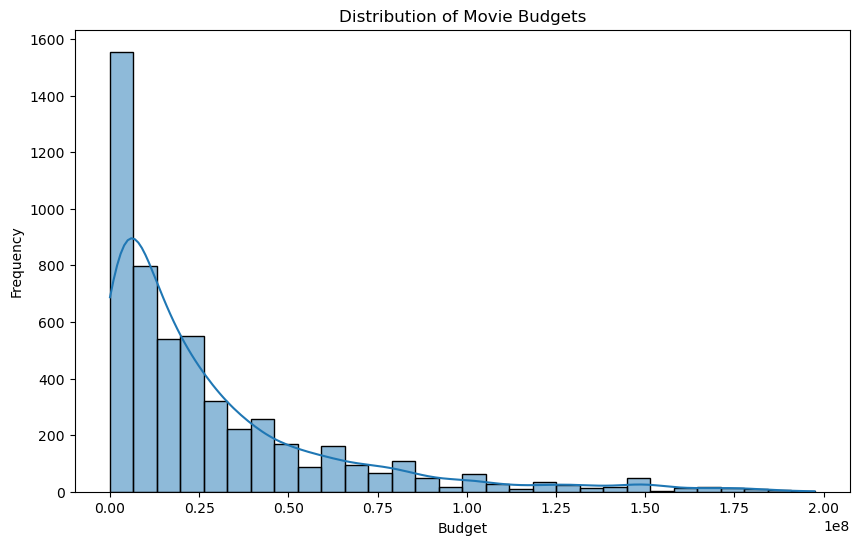

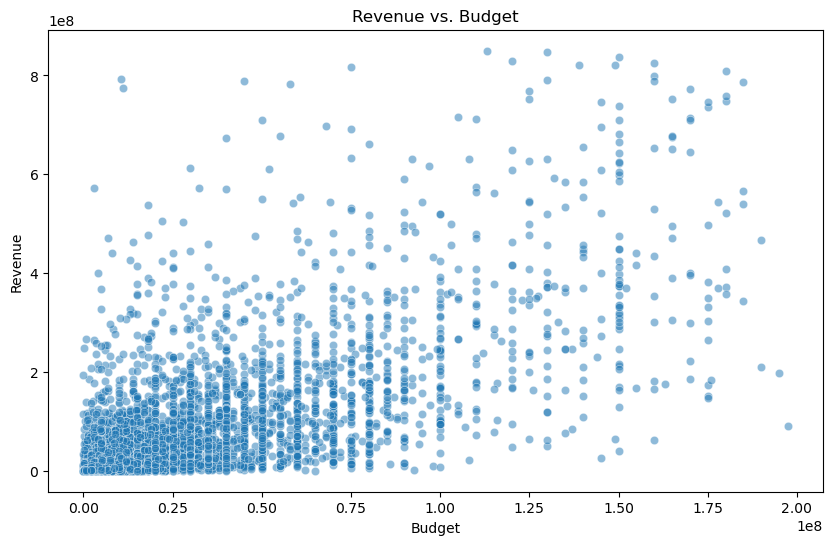

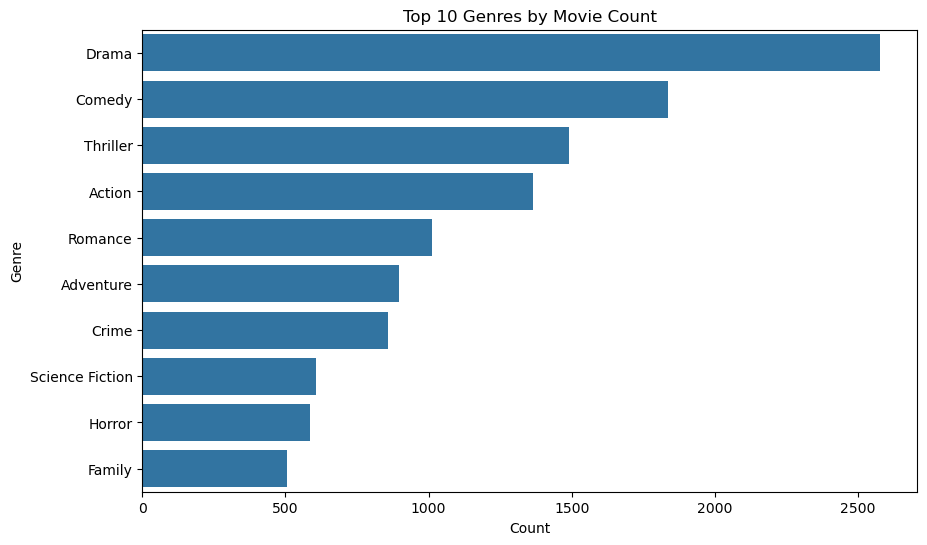

Summary of Cleaned Data:
             budget       revenue        profit           ROI
count  5.299000e+03  5.299000e+03  5.299000e+03  5.299000e+03
mean   2.857843e+07  7.759924e+07  4.902081e+07  5.650943e+03
std    3.414288e+07  1.220458e+08  1.015610e+08  2.185273e+05
min    1.000000e+00  1.000000e+00 -1.191800e+08 -9.999995e-01
25%    5.000000e+06  6.865551e+06 -1.655903e+06 -2.226630e-01
50%    1.600000e+07  2.892126e+07  1.041898e+07  1.017980e+00
75%    3.800000e+07  9.496788e+07  5.854595e+07  3.199235e+00
max    1.974717e+08  8.500000e+08  7.824653e+08  1.239638e+07


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("movies_metadata.csv", low_memory=False)

# 1. Data Cleaning
# Convert budget and revenue to numeric (coerce errors to NaN)
data['budget'] = pd.to_numeric(data['budget'], errors='coerce')
data['revenue'] = pd.to_numeric(data['revenue'], errors='coerce')

# Handle missing values
data['budget'] = data['budget'].fillna(0)  # Replace missing budgets with 0
data['revenue'] = data['revenue'].fillna(0)  # Replace missing revenues with 0

# Remove invalid entries (e.g., movies with a budget or revenue <= 0)
cleaned_data = data[(data['budget'] > 0) & (data['revenue'] > 0)]

# Outlier detection: Remove movies with extreme budget/revenue (99th percentile)
budget_threshold = np.percentile(cleaned_data['budget'], 99)
revenue_threshold = np.percentile(cleaned_data['revenue'], 99)
cleaned_data = cleaned_data[
    (cleaned_data['budget'] < budget_threshold) &
    (cleaned_data['revenue'] < revenue_threshold)
]

# 2. EDA (Visualizations)
# Visualization 1: Distribution of budget
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data['budget'], bins=30, kde=True)
plt.title('Distribution of Movie Budgets')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Revenue vs. Budget scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='budget', y='revenue', data=cleaned_data, alpha=0.5)
plt.title('Revenue vs. Budget')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

# Visualization 3: Top genres by count
# Split genres and count occurrences
cleaned_data['genres'] = cleaned_data['genres'].fillna('[]')
cleaned_data['genres'] = cleaned_data['genres'].apply(eval).apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
genre_counts = pd.Series([genre for genres in cleaned_data['genres'] for genre in genres]).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values[:10], y=genre_counts.index[:10])
plt.title('Top 10 Genres by Movie Count')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# 3. Feature Engineering
# Create a "profit" column
cleaned_data['profit'] = cleaned_data['revenue'] - cleaned_data['budget']

# Create a "ROI" column (return on investment)
cleaned_data['ROI'] = (cleaned_data['profit'] / cleaned_data['budget']).replace([np.inf, -np.inf], np.nan).fillna(0)

# Save cleaned data for future use
cleaned_data.to_csv("cleaned_movies_metadata.csv", index=False)

# Summary of results
print("Summary of Cleaned Data:")
print(cleaned_data[['budget', 'revenue', 'profit', 'ROI']].describe())



# Study 1 - Similarity Measures

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from difflib import SequenceMatcher

# Sample movie dataset (replace with your actual dataset)
data = pd.DataFrame({
    'title': ['Toy Story', 'Titanic', 'Apollo 13', 'Fight Club', 'Matrix', 'Inception', 'The Lion King', 'The Avengers', 'Jurassic Park', 'The Dark Knight'],
    'genre': ['Animation', 'Drama', 'Adventure', 'Drama', 'Sci-Fi', 'Sci-Fi', 'Animation', 'Action', 'Action', 'Action'],
    'revenue': [373554033, 218746394, 35523744, 100853000, 463517383, 829895144, 76345695, 1518812988, 107429496, 1004558444],
    'runtime': [81, 195, 140, 139, 136, 148, 88, 143, 127, 152],
    'budget': [30000000, 200000000, 68000000, 63000000, 63000000, 160000000, 26000000, 220000000, 63000000, 185000000]
})

# 1. Genre Similarity - Jaccard Similarity
def jaccard_similarity(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    return len(set1 & set2) / len(set1 | set2)

def find_similar_by_genre(target_movie, top_n=10):
    target_genre = data.loc[data['title'] == target_movie, 'genre'].values[0]
    data['genre_similarity'] = data['genre'].apply(lambda x: jaccard_similarity(target_genre, str(x)))
    return data.nlargest(top_n, 'genre_similarity')[['title', 'genre', 'genre_similarity']]

# 2. Revenue Similarity - Cosine Similarity
def find_similar_by_revenue(target_movie, top_n=10):
    target_revenue = data.loc[data['title'] == target_movie, 'revenue'].values.reshape(1, -1)
    revenues = data['revenue'].values.reshape(-1, 1)
    cosine_sim = cosine_similarity(target_revenue, revenues)
    data['revenue_similarity'] = cosine_sim.flatten()
    return data.nlargest(top_n, 'revenue_similarity')[['title', 'revenue', 'revenue_similarity']]

# 3. Runtime Similarity - Euclidean Distance
def euclidean_distance(str1, str2):
    return euclidean(np.array([str1]), np.array([str2]))

def find_similar_by_runtime(target_movie, top_n=10):
    target_runtime = data.loc[data['title'] == target_movie, 'runtime'].values[0]
    data['runtime_similarity'] = data['runtime'].apply(lambda x: 1 / (1 + euclidean_distance(target_runtime, x)))  # Normalize similarity
    return data.nlargest(top_n, 'runtime_similarity')[['title', 'runtime', 'runtime_similarity']]

# 4. Title Similarity - Levenshtein Distance (using difflib)
def difflib_similarity(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

def find_similar_by_title(target_movie, top_n=10):
    target_title = data.loc[data['title'] == target_movie, 'title'].values[0]
    data['title_similarity'] = data['title'].apply(lambda x: difflib_similarity(target_title, str(x)))
    return data.nlargest(top_n, 'title_similarity')[['title', 'title_similarity']]

# 5. Budget Similarity - Manhattan Distance
def manhattan_distance(str1, str2):
    return cityblock(np.array([str1]), np.array([str2]))

def find_similar_by_budget(target_movie, top_n=10):
    target_budget = data.loc[data['title'] == target_movie, 'budget'].values[0]
    data['budget_similarity'] = data['budget'].apply(lambda x: 1 / (1 + manhattan_distance(target_budget, x)))  # Normalize similarity
    return data.nlargest(top_n, 'budget_similarity')[['title', 'budget', 'budget_similarity']]

# Example queries to find the Top 10 similar movies for different attributes

# Show movies with the same genre as "Toy Story"
genre_results = find_similar_by_genre("Toy Story")
print("Movies with the same genre as 'Toy Story':")
print(genre_results)

# Show movies with similar revenue to "Titanic"
revenue_results = find_similar_by_revenue("Titanic")
print("\nMovies with similar revenue to 'Titanic':")
print(revenue_results)

# Show movies with similar runtime to "Apollo 13"
runtime_results = find_similar_by_runtime("Apollo 13")
print("\nMovies with similar runtime to 'Apollo 13':")
print(runtime_results)

# Show movies with similar title to "Fight Club"
title_results = find_similar_by_title("Fight Club")
print("\nMovies with similar title to 'Fight Club':")
print(title_results)

# Show movies with similar budget to "Matrix"
budget_results = find_similar_by_budget("Matrix")
print("\nMovies with similar budget to 'Matrix':")
print(budget_results)


Movies with the same genre as 'Toy Story':
             title      genre  genre_similarity
0        Toy Story  Animation               1.0
6    The Lion King  Animation               1.0
1          Titanic      Drama               0.0
2        Apollo 13  Adventure               0.0
3       Fight Club      Drama               0.0
4           Matrix     Sci-Fi               0.0
5        Inception     Sci-Fi               0.0
7     The Avengers     Action               0.0
8    Jurassic Park     Action               0.0
9  The Dark Knight     Action               0.0

Movies with similar revenue to 'Titanic':
             title     revenue  revenue_similarity
0        Toy Story   373554033                 1.0
1          Titanic   218746394                 1.0
2        Apollo 13    35523744                 1.0
3       Fight Club   100853000                 1.0
4           Matrix   463517383                 1.0
5        Inception   829895144                 1.0
6    The Lion King    7634569